In [40]:
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary

In [2]:
# Load the Fashion MNIST dataset using torchvision
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

In [3]:
# Define the preprocessing function
def preprocess(imgs):
    imgs = imgs.float() / 255.0  # Convert to float32 and normalize to [0, 1]
    imgs = torch.nn.functional.pad(imgs, (2, 2, 2, 2), mode='constant', value=0.0)  # Pad with 0s
    imgs = imgs.unsqueeze(1)  # Add channel dimension
    return imgs

# Extract and preprocess the data
x_train = preprocess(train_dataset.data)
x_test = preprocess(test_dataset.data)

# Extract labels
y_train = train_dataset.targets
y_test = test_dataset.targets

### Autoencoder:<br>
Autoencoder is a neural network made up of two parts:
 * An `encoder` network that compresses high dimensional input data into a lower dimensional embedding vector
 * A `decoder` network that decompresses a given back to the original domain e.g., back to an image.

### Encoder Architecture
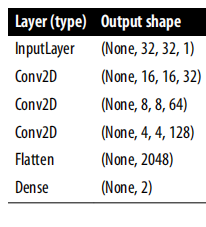

In [74]:
class Encoder(nn.Module):
    def __init__(self, in_channel):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.flat = nn.Flatten(start_dim=0)
        self.fc = None

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        flattened_features = x.size()[0] # This should be defined outside the conditional block
        # if self.fc is None:
        #     self.fc = nn.Linear(flattened_features, 2)
        # x = self.fc(x)
        return x,flattened_features

encoder=Encoder(1)
# summary(encoder, (1,32,32))
_,flt=encoder.forward(x_train[0])
flt

2048

### Decoder Architecture
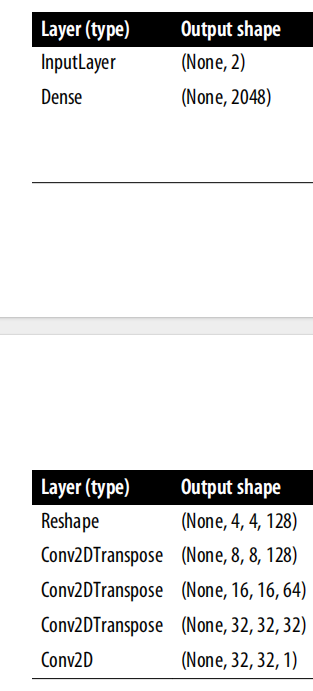

In [83]:
# Decoder Architecture

class Decoder(nn.Module):
    def __init__(self, decoder_in_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2, decoder_in_size)
        self.convT1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.convT2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0)
        self.convT3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, padding=0)
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, 128, 4, 4)
        x = F.relu(self.convT1(x))
        x = F.relu(self.convT2(x))
        x = F.relu(self.convT3(x))
        x = torch.sigmoid(self.conv1(x))
        return x

# Initialize the model components
encoder = Encoder(in_channel=x_test.shape[1])
_, flattened_features = encoder.forward(x_test[0])
decoder = Decoder(decoder_in_size=flattened_features)
summary(decoder,(1,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 2048]           6,144
   ConvTranspose2d-2            [-1, 128, 8, 8]          65,664
   ConvTranspose2d-3           [-1, 64, 16, 16]          32,832
   ConvTranspose2d-4           [-1, 32, 32, 32]           8,224
            Conv2d-5            [-1, 1, 32, 32]              33
Total params: 112,897
Trainable params: 112,897
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.46
Params size (MB): 0.43
Estimated Total Size (MB): 0.89
----------------------------------------------------------------


In [52]:
flattened_features

16

### Combine Encoder and Decoder

In [7]:

class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded, _ = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### Define the training loop

In [140]:
import torch.optim as optim

# Initialize encoder and decoder
encoder = Encoder(in_channel=x_train.shape[1])
_, flattened_features = encoder.forward(x_train[0:1])  # Pass a single example to get the flattened size
decoder = Decoder(decoder_in_size=flattened_features)

# Combine them into an autoencoder
autoencoder = Autoencoder(encoder, decoder)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Example training loop
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
        inputs = x_train[i:i + batch_size]  # Assuming x_train is a tensor of shape [N, C, H, W]
        
        # Forward pass
        outputs = autoencoder(inputs)
        
        # Compute loss
        loss = criterion(outputs, inputs)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


### Inference

### Inference

In [15]:
# Initialize the model components
encoder = Encoder(in_channel=x_test.shape[1])
_, flattened_features = encoder.forward(x_test[0])
decoder = Decoder(decoder_in_size=flattened_features)

# instantiate autoencoder
autoencoder_model = Autoencoder(encoder, decoder)
autoencoder_model

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (flat): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=16, bias=True)
    (convT1): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
    (convT2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (convT3): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (conv1): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

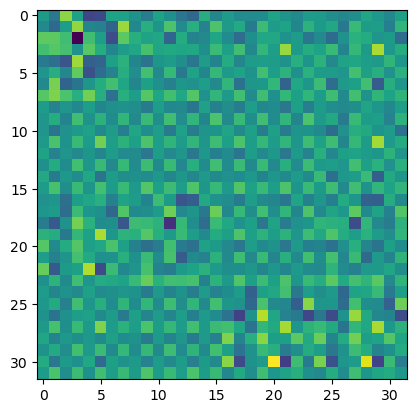

In [31]:
autoencoder_model.eval()
i=1
with torch.no_grad():
    sample_input=  x_test[i]
    output = autoencoder_model(sample_input)
plt.imshow(output.reshape(32,32,1))

In [36]:
for p in encoder.parameters():
    # print(p)
    p.size
    break

In [41]:
sum(p.numel() for p in encoder.parameters())

92706